In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz  ## REQUIRES GRAPHVIZ INSTALLED!
from typing import Tuple


In [2]:
np.random.seed(42)


In [3]:
data = load_iris()
X = data.data
y = data.target


In [4]:
X.shape, y.shape


((150, 4), (150,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [6]:
class Node:
    def __init__(
        self,
        depth: int,
        split_attribute_idx: int = None,
        split_attribute_name: str = None,
        split_threshold: float = None,
        entropy: float = None,
        samples: int = None,
        values: np.ndarray = None,
        label: int = None,
        label_name: str = None,
    ) -> None:
        self.depth = depth
        self.split_attribute_idx = split_attribute_idx
        self.split_attribute_name = split_attribute_name
        self.split_threshold = split_threshold
        self.entropy = entropy
        self.samples = samples
        self.values = values
        self.label = label
        self.label_name = label_name
        self.right = None
        self.left = None

    def __str__(self):
        node_str = f"Depth: {self.depth}, "
        if self.split_attribute_name is not None:
            node_str += f"Split attribute: {self.split_attribute_name}, threshold: {self.split_threshold}, "
        elif self.split_attribute_idx is not None:
            node_str += f"Split attribute index: {self.split_attribute_idx}, threshold: {self.split_threshold}, "
        if self.label_name is not None:
            node_str += f"entropy: {self.entropy:.3f}, samples: {self.samples}, values: {self.values}, label: {self.label_name}"
        else:
            node_str += f"entropy: {self.entropy:.3f}, samples: {self.samples}, values: {self.values}, label: {self.label}"
        return node_str


In [7]:
class DecisionTree:
    def __init__(
        self,
        max_depth: int,
        min_entropy_diff: float,
        min_node_size: int,
        max_num_attributes: int = None,
    ) -> None:
        self.root = None
        self.max_depth = max_depth
        self.min_entropy_diff = min_entropy_diff
        self.min_node_size = min_node_size
        self.max_num_attributes = max_num_attributes

    def _entropy(self, s: np.ndarray) -> float:
        """Calculates entropy of current dataset s
        according to formula:
        H(s) = sum(-p(x)*log2(p(x))),
        where p(x) is the proportion of the number of elements
        in class x to the number of elements in set s

        Args:
            s (np.ndarray): current dataset to calculate entropy on

        Returns:
            float: entropy of dataset s
        """
        y = s[:, -1]
        result = 0
        counts = np.unique(y, return_counts=True)[1]
        for count in counts:
            proportion = count / y.shape[0]
            result += -proportion * np.log2(proportion + 1e-5)
        return result

    def _find_split(
        self, s: np.ndarray
    ) -> Tuple[int, float, float, np.ndarray, np.ndarray]:
        """Finds best attribute and threshold to split node on

        Args:
            s (np.ndarray): current dataset of node

        Returns:
            Tuple[int, float, float, np.ndarray, np.ndarray]: split attribute index, threshold, split entropy, left subset, right subset
        """
        min_split_entropy = np.inf
        best_split_attr_idx = None
        best_threshold = None
        best_left_subset = None
        best_right_subset = None

        possible_attributes = (
            range(s.shape[1] - 1)
            if self.max_num_attributes is None
            else np.random.choice(
                range(s.shape[1] - 1), size=self.max_num_attributes, replace=False
            )
        )
        for attribute_idx in possible_attributes:
            for threshold in np.unique(s[:, attribute_idx]):

                left_subset = np.array(
                    [row for row in s if row[attribute_idx] < threshold]
                )
                right_subset = np.array(
                    [row for row in s if row[attribute_idx] >= threshold]
                )

                left_entropy = (
                    (len(left_subset) / len(s)) * self._entropy(left_subset)
                    if left_subset.shape[0] > 0
                    else 0
                )
                right_entropy = (
                    (len(right_subset) / len(s)) * self._entropy(right_subset)
                    if right_subset.shape[0] > 0
                    else 0
                )

                split_entropy = left_entropy + right_entropy
                if split_entropy < min_split_entropy:
                    min_split_entropy = split_entropy
                    best_split_attr_idx = attribute_idx
                    best_threshold = threshold
                    best_left_subset = left_subset
                    best_right_subset = right_subset

        return (
            best_split_attr_idx,
            best_threshold,
            min_split_entropy,
            best_left_subset,
            best_right_subset,
        )

    def _build_id3(
        self,
        dataset: np.ndarray,
        depth: int,
        orig_classes: np.ndarray,
        attribute_labels: np.ndarray = None,
        class_labels: np.ndarray = None,
    ) -> Node:
        if dataset.shape[0] == 0:
            return None

        X, y = dataset[:, :-1], dataset[:, -1].astype("int64")

        # all examples classified as one class
        if np.unique(y).shape[0] == 1:
            return Node(
                depth=depth,
                values=[y.tolist().count(c) for c in orig_classes],
                entropy=0.0,
                label=np.argmax([y.tolist().count(c) for c in orig_classes]),
                label_name=class_labels[
                    np.argmax([y.tolist().count(c) for c in orig_classes])
                ]
                if class_labels is not None
                else np.argmax([y.tolist().count(c) for c in orig_classes]),
                samples=dataset.shape[0],
            )

        # no attributes to split upon
        if X.shape[1] == 0:
            return Node(
                depth=depth,
                values=[y.tolist().count(c) for c in orig_classes],
                entropy=self._entropy(dataset),
                label=np.argmax([y.tolist().count(c) for c in orig_classes]),
                label_name=class_labels[
                    np.argmax([y.tolist().count(c) for c in orig_classes])
                ]
                if class_labels is not None
                else np.argmax([y.tolist().count(c) for c in orig_classes]),
                samples=dataset.shape[0],
            )

        (
            best_split_attr_idx,
            best_threshold,
            min_split_entropy,
            best_left_subset,
            best_right_subset,
        ) = self._find_split(dataset)

        # decide about splitting
        if (
            depth < self.max_depth
            and (self._entropy(dataset) - min_split_entropy) > self.min_entropy_diff
            and (best_left_subset.shape[0] > self.min_node_size)
            and (best_right_subset.shape[0] > self.min_node_size)
        ):
            root = Node(
                depth=depth,
                split_attribute_idx=best_split_attr_idx,
                split_attribute_name=attribute_labels[best_split_attr_idx]
                if attribute_labels is not None
                else None,
                split_threshold=best_threshold,
                entropy=self._entropy(dataset),
                samples=dataset.shape[0],
                values=[y.tolist().count(c) for c in orig_classes],
                label=np.argmax([y.tolist().count(c) for c in orig_classes]),
                label_name=class_labels[
                    np.argmax([y.tolist().count(c) for c in orig_classes])
                ]
                if class_labels is not None
                else np.argmax([y.tolist().count(c) for c in orig_classes]),
            )
            root.left = self._build_id3(
                best_left_subset,
                depth=depth + 1,
                orig_classes=orig_classes,
                attribute_labels=attribute_labels,
                class_labels=class_labels,
            )
            root.right = self._build_id3(
                best_right_subset,
                depth=depth + 1,
                orig_classes=orig_classes,
                attribute_labels=attribute_labels,
                class_labels=class_labels,
            )

        else:
            root = Node(
                depth=depth,
                entropy=self._entropy(dataset),
                samples=dataset.shape[0],
                values=[y.tolist().count(c) for c in orig_classes],
                label=np.argmax([y.tolist().count(c) for c in orig_classes]),
                label_name=class_labels[
                    np.argmax([y.tolist().count(c) for c in orig_classes])
                ]
                if class_labels is not None
                else np.argmax([y.tolist().count(c) for c in orig_classes]),
            )

        return root

    def visualize(self) -> None:
        queue = list()
        queue.append(self.root)

        while queue:
            v = queue.pop(0)
            print(v)
            if v.left is not None:
                queue.append(v.left)
            if v.left is not None:
                queue.append(v.right)

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        attribute_labels: np.ndarray = None,
        class_labels: np.ndarray = None,
    ) -> None:
        if attribute_labels is not None:
            if attribute_labels.shape[0] != X.shape[1]:
                raise Exception("Invalid shape of given attribute labels")

        if class_labels is not None:
            if class_labels.shape[0] != np.unique(y).shape[0]:
                raise Exception("Invalid shape of given class labels")

        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)

        dataset = np.concatenate([X, y], axis=1)
        self.root = self._build_id3(
            dataset,
            depth=0,
            orig_classes=np.unique(y),
            attribute_labels=attribute_labels,
            class_labels=class_labels,
        )

    def _predict_sample(self, sample: np.ndarray) -> int:
        current_node = self.root
        current_prediction = current_node.label
        while current_node.split_attribute_idx is not None:
            if sample[current_node.split_attribute_idx] < current_node.split_threshold:
                current_prediction = current_node.left.label
                current_node = current_node.left
            else:
                current_prediction = current_node.right.label
                current_node = current_node.right

        return current_prediction

    def predict(self, X: np.ndarray) -> np.ndarray:
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        if self.root is not None:
            return np.array([self._predict_sample(sample) for sample in X])
        else:
            raise Exception("Decision Tree is not trained yet")


In [8]:
class RandomForest:
    def __init__(
        self,
        num_trees: int,
        tree_max_depth: int,
        tree_min_entropy_diff: float,
        tree_min_node_size: int,
        tree_max_num_attributes: int = None,
    ):
        self.tree_max_depth = tree_max_depth
        self.tree_min_entropy_diff = tree_min_entropy_diff
        self.tree_min_node_size = tree_min_node_size
        self.tree_max_num_attributes = tree_max_num_attributes
        self.num_trees = num_trees
        self.trees = []

    def _bootstrap_dataset(self, dataset: np.ndarray):
        chosen_idxs = np.random.choice(
            dataset.shape[0], size=dataset.shape[0], replace=True
        )
        return dataset[chosen_idxs]

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        attribute_labels: np.ndarray = None,
        class_labels: np.ndarray = None,
    ) -> None:
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)

        dataset = np.concatenate([X, y], axis=1)
        if self.tree_max_num_attributes > dataset.shape[1] - 1:
            raise Exception("Invalid number of max attributes in Decision Tree")

        for _ in range(self.num_trees):
            boostrapped_dataset = self._bootstrap_dataset(dataset)
            tree = DecisionTree(
                max_depth=self.tree_max_depth,
                min_entropy_diff=self.tree_min_entropy_diff,
                min_node_size=self.tree_min_node_size,
                max_num_attributes=boostrapped_dataset.shape[1] - 1
                if self.tree_max_num_attributes is None
                else self.tree_max_num_attributes,
            )
            tree.fit(
                boostrapped_dataset[:, :-1],
                boostrapped_dataset[:, -1],
                attribute_labels=attribute_labels,
                class_labels=class_labels,
            )
            self.trees.append(tree)

    def _predict_sample(self, sample: np.ndarray) -> int:
        return np.bincount(
            np.squeeze([tree.predict(sample) for tree in self.trees])
        ).argmax()

    def predict(self, X: np.ndarray) -> np.ndarray:
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        if len(self.trees) > 0:
            return np.array([self._predict_sample(sample) for sample in X])
        else:
            raise Exception("Random Forest is not trained yet")

    def visualize(self) -> None:
        for i, tree in enumerate(self.trees):
            print("-" * 100)
            print(f"Tree {i+1}:")
            tree.visualize()
            print("-" * 100)


In [9]:
random_forest = RandomForest(
    tree_max_depth=2,
    tree_min_entropy_diff=0.01,
    tree_min_node_size=20,
    tree_max_num_attributes=3,
    num_trees=3,
)


In [10]:
random_forest.fit(
    X_train,
    y_train,
    attribute_labels=np.array(data.feature_names),
    class_labels=data.target_names,
)


In [11]:
random_forest.visualize()


----------------------------------------------------------------------------------------------------
Tree 1:
Depth: 0, Split attribute: petal length (cm), threshold: 3.0, entropy: 1.579, samples: 120, values: [39, 45, 36], label: versicolor
Depth: 1, entropy: 0.000, samples: 39, values: [39, 0, 0], label: setosa
Depth: 1, Split attribute: petal length (cm), threshold: 5.1, entropy: 0.991, samples: 81, values: [0, 45, 36], label: versicolor
Depth: 2, entropy: 0.342, samples: 47, values: [0, 44, 3], label: versicolor
Depth: 2, entropy: 0.191, samples: 34, values: [0, 1, 33], label: virginica
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Tree 2:
Depth: 0, Split attribute: petal length (cm), threshold: 3.5, entropy: 1.553, samples: 120, values: [52, 33, 35], label: setosa
Depth: 1, entropy: 0.000, samples: 52, values: [52, 0, 0], label:

In [12]:
predictions = random_forest.predict(X_test)


In [13]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



#### Model from Sklearn as reference

In [14]:
sklearn_random_forest = RandomForestClassifier(
    n_estimators=3,
    criterion="entropy",
    max_depth=2,
    min_samples_split=20,
    max_features=3,
    min_impurity_decrease=0.01,
    random_state=42,
    min_samples_leaf=20,
)


In [15]:
sklearn_random_forest.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=2, max_features=3,
                       min_impurity_decrease=0.01, min_samples_leaf=20,
                       min_samples_split=20, n_estimators=3, random_state=42)

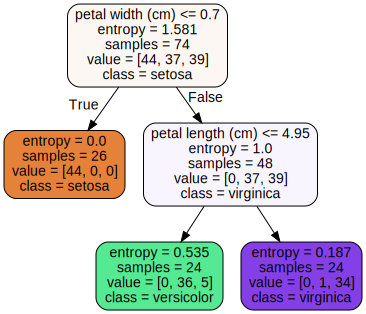

In [16]:
tree0 = sklearn_random_forest.estimators_[0]
graph0 = export_graphviz(
    tree0,
    out_file=None,
    feature_names=data.feature_names,
    class_names=data.target_names,
    rounded=True,
    proportion=False,
    filled=True,
)
graphviz.Source(graph0, format="png")


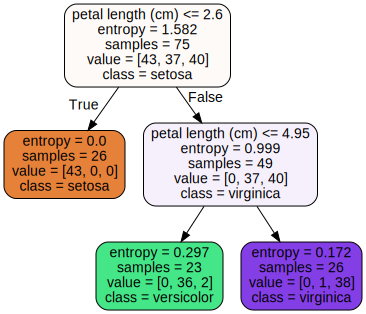

In [17]:
tree1 = sklearn_random_forest.estimators_[1]
graph1 = export_graphviz(
    tree1,
    out_file=None,
    feature_names=data.feature_names,
    class_names=data.target_names,
    rounded=True,
    proportion=False,
    filled=True,
)
graphviz.Source(graph1, format="png")


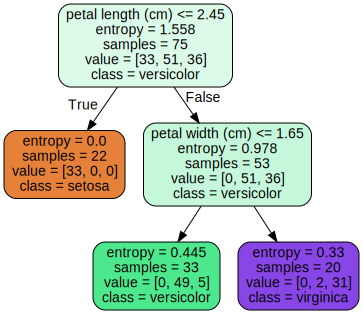

In [18]:
tree2 = sklearn_random_forest.estimators_[2]
graph2 = export_graphviz(
    tree2,
    out_file=None,
    feature_names=data.feature_names,
    class_names=data.target_names,
    rounded=True,
    proportion=False,
    filled=True,
)
graphviz.Source(graph2, format="png")


In [19]:
predictions_sklearn = sklearn_random_forest.predict(X_test)


In [20]:
print(classification_report(y_test, predictions_sklearn))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

